<a href="https://colab.research.google.com/github/marvinmouroum/cv-heart-rate-measurement/blob/master/cv_heart_rate_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face detection

### Initialize the Code

In [0]:
import os
import cv2
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
from googleapiclient.http import MediaIoBaseDownload
from google.colab import drive as gdrive

In [2]:
gdrive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Project/'
source_path = 'gdrive/My Drive/cohface/'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Define paths
prototxt_path = os.path.join(root_path + 'deploy.prototxt')
caffemodel_path = os.path.join(root_path + 'weights.caffemodel')

prototxt_path_id = '1-zfDOBY5fVcEzwii2JlrIDFyhLyvu5m5'
caffemodel_path_id = '1jxuFoSukXr78rLfBgkLwn2qiWNUfoONf'
image_id = '1wb8whYMorQNU2YvmHZsZGFeUTDc-95DN'

downloaded = drive.CreateFile({'id': prototxt_path_id})
downloaded.GetContentFile('deploy.prototxt')

downloaded = drive.CreateFile({'id': caffemodel_path_id})
downloaded.GetContentFile('weights.caffemodel')

# Read the model
model = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

### Proof of Concept

Not needed for running for the detection

In [0]:
!ls gdrive/My\ Drive/Project

deploy.prototxt  example.jpg  weights.caffemodel


In [0]:
# Create directory 'updated_images' if it does not exist
if not os.path.exists('updated_images'):
	print("New directory created")
	os.makedirs('updated_images')

New directory created


In [0]:
# Create directory 'faces' if it does not exist
if not os.path.exists('faces'):
	print("New directory created")
	os.makedirs('faces')

New directory created


In [0]:
!ls images

ls: cannot access 'images': No such file or directory


In [0]:
# Loop through all images and save images with marked faces
for file in os.listdir('images'):
	file_name, file_extension = os.path.splitext(file)
	if (file_extension in ['.png','.jpg']):
		print("Image path: {}".format('images/' + file))

FileNotFoundError: ignored

In [0]:
image = cv2.imread('images/' + file)

(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

model.setInput(blob)
detections = model.forward()

In [0]:
# Create frame around face
for i in range(0, detections.shape[2]):
  box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
  (startX, startY, endX, endY) = box.astype("int")

  confidence = detections[0, 0, i, 2]

  # If confidence > 0.5, show box around face
  if (confidence > 0.5):
    cv2.rectangle(image, (startX, startY), (endX, endY), (255, 255, 255), 2)

cv2.imwrite('updated_images/' + file, image)
print("Image " + file + " converted successfully")

In [0]:
count = 0
# Identify each face
for i in range(0, detections.shape[2]):
  box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
  (startX, startY, endX, endY) = box.astype("int")

  confidence = detections[0, 0, i, 2]

  # If confidence > 0.5, save it as a separate file
  if (confidence > 0.5):
    count += 1
    frame = image[startY:endY, startX:endX]
    cv2.imwrite('faces/' + str(i) + '_' + file, frame)

In [0]:
!ls updated_images

In [0]:
from IPython.display import Image
display(Image('updated_images/image.jpg'))
display(Image('faces/0_image.jpg'))

In [0]:
downloaded = drive.CreateFile({'id': '10d5-_YC2lX09LfnbbvraW0GoAKeqXUDu'})
downloaded.GetContentFile('videos/data.avi')

## Video Implementation

### This sections creates a local document structure in order to 

*   save a video locally in *temp_video*
*   extract the face and save the image with bounding box locally in *bounding*
*   extract the face and save it in a specified folder *faces/videoID*
*   resize the face and save it in the directory *resized/videoID






In [0]:
#This will clean the creates data
def clean(temp='temp_video',bound='bounding',faces='faces',resized='resized'):
  !rm -r $temp
  !rm -r $bound
  !rm -r $faces
  !rm -r $resized 

#This will create all the necessary directories in order to perform the preprocessing
def create_infrastructure(temp='temp_video',bound='bounding',faces='faces',resized='resized'):
  !mkdir $temp
  !mkdir $bound
  !mkdir $faces
  !mkdir $resized
  !mkdir 'gdrive/My Drive/cohface/frames'

#This will copy a video from the drive in the respective directory and create a folder dedicated to it's id
def getVideo(path,id,faces='faces',bound='bounding',resized='resized',temp='temp_video'):
  !mkdir $faces/$id
  !mkdir $bound/$id
  !mkdir $resized/$id
  filetype = path.split('.')[-1]
  target   = "'" + temp + '/' + id + '.' + filetype + "'"
  source   = "'" + path + "'"
  #print("!cp" + " " + source + " " + target)
  !cp $path $target
  return temp + '/' + id + '.' + filetype

In [0]:
def resize_img(img,destination):
  # Create square images from pepes by adding black margins preserving original aspect ratio
  #Importing modules opencv + numpy
  import cv2
  import numpy as np

  w = 128
  h = 192

  #Reading an image (you can use PNG or JPG)
  img = cv2.imread(img)

  if(img.shape[0] > h or img.shape[1] > w):
    #print("bigger image detected")
    img = cv2.resize(img,(w,h))

  if img is None:
    return False

  #Creating a dark square with NUMPY  
  f = np.zeros((h,w,3),np.uint8)

  #Getting the centering position
  ax,ay = (w - img.shape[1])//2,(h - img.shape[0])//2

  #Pasting the 'image' in a centering position
  f[ay:img.shape[0]+ay,ax:ax+img.shape[1]] = img
  

  #Saving the image
  f = cv2.resize(f,(w,h),interpolation=cv2.INTER_NEAREST)
  cv2.imwrite(destination,f)
  cv2.destroyAllWindows() 
  return True

In [0]:
def find_face(image,id,fileID,bound='bounding',faces='faces'):

  count = 0

  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

  model.setInput(blob)
  detections = model.forward()
  # Create frame around face
  for i in range(0, detections.shape[2]):
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    confidence = detections[0, 0, i, 2]

    # If confidence > 0.5, show box around face
    if (confidence > 0.5):
      cv2.rectangle(image, (startX, startY), (endX, endY), (255, 255, 255), 2)
      #print(endX-startX)
      #print(endY-startY)
    
  cv2.imwrite( bound + '/' + id + '/' + fileID + '.png', image)

    # Identify each face
  for i in range(0, detections.shape[2]):
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    confidence = detections[0, 0, i, 2]

    # If confidence > 0.5, save it as a separate file
    if (confidence > 0.5):
      count += 1
      frame = image[startY:endY, startX:endX]
      #print(faces + '/' + id + '/' + fileID + '.png')
      cv2.imwrite( faces + '/' + id + '/' + fileID + '.png', frame)
      #cv2_imshow(frame)
      resize_img(faces + '/' + id + '/' + fileID + '.png','resized/' + id + '/' + fileID + '.png')


In [0]:
def analyze_video(video,id,temp='temp_video'):

  # load video stream
  VIDEO_STREAM =  temp + '/' + video

  # Initialize the video stream and pointer to output video file
  vs = cv2.VideoCapture(VIDEO_STREAM)
  writer = None
  vs.set(cv2.CAP_PROP_POS_FRAMES, 1);
  i = 0
  while i < 20000:
    # read the next frame from the file
    (grabbed, frame) = vs.read()
    i += 1
    # If the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
      print("Not grabbed.")
      break;
    newID = id + str(i)
    find_face(frame,id,newID)
    if i%100 == 0:
      print(i)
    #break


### This section generates frames only of the face and saves them in a folder on the drive and local storage

In [0]:
from google.colab.patches import cv2_imshow

myid = '1_0'
clean()
create_infrastructure()
filepath = getVideo('gdrive/My\ Drive/cohface/1/0/data.avi',myid)
filename = filepath.split("/")[-1]
analyze_video(filename,myid)

destination = 'gdrive/My\ Drive/cohface/frames/' + myid
_destination = "'" + 'gdrive/My Drive/cohface/frames/' + myid + "'" 
_source = "'resized/"+myid+"/.'"
!mkdir $destination
!cp -a $_source $_destination


mkdir: cannot create directory ‘gdrive/My Drive/cohface/frames’: File exists
100
200
300
400
500
600
700
800
900
1000
1100
1200
Not grabbed.


In [0]:
def getVideos(random, vtype, nb, path, videosPaths):
    if nb > len(videosPaths):
      for file in os.listdir(path): # Get files and directories of the directory
          _, currVidType = os.path.splitext(file)
          if os.path.isdir(file): # This is a directory
              getVideos(random, vtype, nb, path+'/'+file, videosPaths) 
          elif currVidType == '.'+vtype: # This is a file with the good video type
              videosPaths.append(path+'/'+file)
    return videosPaths 

In [0]:
def script(random, vtype, nb, directories):
  videosPaths = []
  if len(directories)==0:
    currentdirpath = os.getcwd()
    videosPaths = getVideos(random, vtype, nb, currentdirpath, videosPaths)
  else: 
    # there is no directory	 
    for i in range(0,len(directories)):
        videosPaths += getVideos(random, vtype, nb, directories[i],videosPaths)  
       
  return videosPaths

## Here will be the dataloader that organizes the dataset for our training

In [210]:
import h5py
#library documentation: http://docs.h5py.org/en/stable/quick.html

f = h5py.File('gdrive/My Drive/cohface/36/3/data.hdf5', 'r')

list(f.keys())


['pulse', 'respiration', 'time']

In [0]:
dset = f['pulse']
tset = f['time'] #in seconds

In [212]:
print(dset.shape)
tset.shape
int(tset[-1])

(15696,)


61

[26.84432943 26.95131363 27.05744159 ... 35.4810012  35.47031321
 35.45946952]
37.059629459734964
1.926139663053773
0.8575005523234406


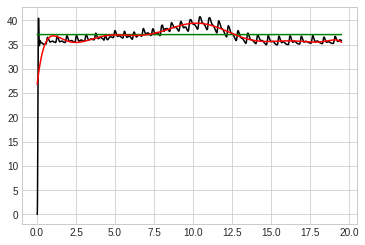

In [213]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import statistics

avg = statistics.mean(dset)
sd = statistics.stdev(dset)

stp = 5000
avgV = [avg] * stp

#have a look at the data
plt.plot(tset[0:stp], dset[0:stp], '-', color='black');
plt.plot(tset[0:stp], avgV, '-', color='green');

# calculate polynomial
z = np.polyfit(tset[0:stp], dset[0:stp], 10)
f = np.poly1d(z)

y_new = f(tset[0:stp])
print(y_new)
plt.plot(tset[0:stp], y_new, '-', color='red');

minValue = min(dset[2000:4000])
maxValue = max(dset[2000:4000])

print(avg)
print(sd)

print(minValue/maxValue)

In [0]:
def extract_hr(xset,yset,start=1,end=2000):
   old_value = yset[0]
   old_t = xset[0]
   old_abs_t = 0

   vector = np.zeros((int(xset[-1])))

   valley = False

   nu = statistics.mean(yset)
   std = statistics.stdev(yset)

   # calculate polynomial
   z = np.polyfit(xset[50:-1], yset[50:-1], 12)
   f = np.poly1d(z)
  
   y_new = f(xset)
   plt.plot(xset[50:-1], y_new[50:-1], '-', color='red');
   plt.show()


   for i in range(start,end):
     
     if i >= yset.size or i >= y_new.size:
       break

     if yset[i] < y_new[i] and not valley:
        valley = True

     if yset[i] > y_new[i]+std*0.5 and valley:
        valley = False
        
        #print(str(int(60/(xset[i]-old_t))) + " bpm at " + str(old_abs_t) )
        if old_abs_t == int(xset[-1]):
          break

        if vector[old_abs_t] == 0:
          vector[old_abs_t] = int(60/(xset[i]-old_t))

        old_t = xset[i]

     if int(xset[i]) > old_abs_t:
       old_abs_t = int(xset[i])

   print(vector[0:-2])
     

In [205]:
extract_hr(tset,dset,0,16000)

[731.  90.  93.  90.  86.  83.  78.  81.  83.  83.  83.  85.  81.  75.
  74.  79.  79.  77.  80.  83.  82.  76.  77.  79.  78.  76.  78.  80.
  78.  79.  80.  85.  84.  83.  84.  81.  79.  77.  80.  85.  83.  79.
  83.  84.  78.  76.  80.  81.  80.  81.  87.  83.  78.  82.  83.  79.
  78.  82.]


In [0]:
def heartRateForSubjects():
  for i in range(1,40):
    print("\nsubject " + str(i) + "\n_________________")
    f = h5py.File('gdrive/My Drive/cohface/' + str(i) + '/1/data.hdf5', 'r')
    dset = f['pulse']
    tset = f['time']
    plt.plot(tset[50:-1], dset[50:-1], '-', color='black');
    extract_hr(tset,dset,0,16000)




subject 1
_________________


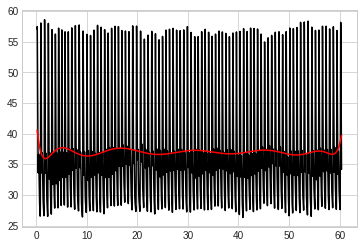

[384.  81.  80.  83.  93.  94.  91.  84.  79.  77.  84.  86.  86.  84.
  86.  89.  88.  85.  85.  81.  76.  80.  82.  82.  84.  87.  86.  85.
  85.  85.  82.  83.  87.  87.  86.  88.  89.  86.  85.  85.  85.  86.
  87.  87.  86.  86.  86.  83.  83.  84.  84.  85.  83.  79.  80.  84.
  86.  85.]

subject 2
_________________


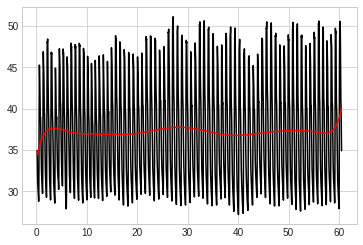

[903.  77.  76.  71.  78.  80.  75.  74.  72.  72.  73.  79.  76.  73.
  73.  73.  70.  69.  67.  67.  68.  71.  69.  66.  66.  69.  70.  66.
  66.  65.  66.  70.  71.  69.  67.  66.  70.  72.  70.  68.  65.  63.
  64.  69.  71.  69.  66.  66.  67.  69.  71.  69.  68.  68.  70.  72.
  70.  70.]

subject 3
_________________


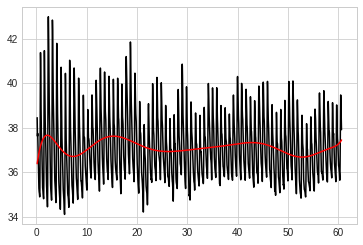

[960.  77.  78.  73.  68.  71.  71.  68.  65.  64.  66.  73.  72.  70.
  68.  67.  70.  73.  70.  65.  62.  64.  74.  73.  68.  66.  69.  73.
  78.  68.  65.  65.  67.  73.  75.  72.  69.  70.  72.  77.  70.  68.
  68.  71.  73.  69.  65.  66.  71.  74.  77.  67.  64.  64.  70.  72.
  71.  68.]

subject 4
_________________


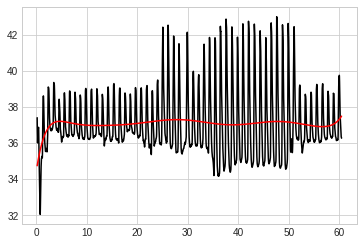

[903.  48.  58.  55.  54.  60.  56.  56.  58.  57.  53.  53.   0.  54.
  56.  52.  51.  54.  57.  59.  55.  53.  53.  59.  60.  55.   0.  54.
  55.  37.  50.   0.  56.  57.  53.  53.  56.  53.  51.  54.  56.  53.
   0.  52.  52.  53.  56.  54.  52.  53.  55.   0.  51.  51.  54.  54.
  52.  52.]

subject 5
_________________


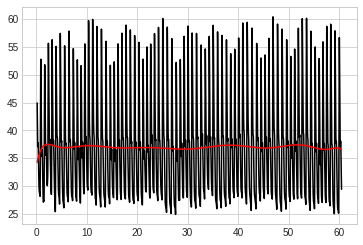

[1024.   76.   83.   81.   71.   69.   70.   69.   74.   83.   80.   73.
   67.   66.   69.   77.   80.   72.   71.   70.   70.   72.   80.   80.
   75.   71.   66.   67.   74.   80.   77.   69.   66.   71.   77.   69.
   68.   67.   71.   75.   77.   67.   64.   63.   69.   76.   79.   66.
   65.   66.   72.   79.   77.   70.   69.   70.   75.   80.]

subject 6
_________________


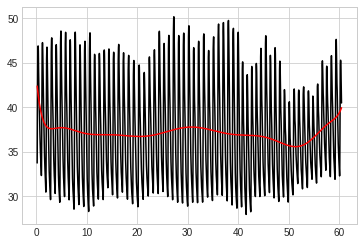

[204.  71.  67.  66.  65.  64.  65.  61.  61.  62.  61.  61.  64.  62.
  64.  64.  61.  61.  59.  58.  56.  58.  60.  60.  61.  62.  64.  61.
  60.  61.  59.  60.  62.  60.  61.  61.  62.  61.  61.  62.  64.  65.
  65.  66.  67.  62.  64.  65.  63.  64.  63.  64.  63.  62.  65.  66.
  65.  67.]

subject 7
_________________


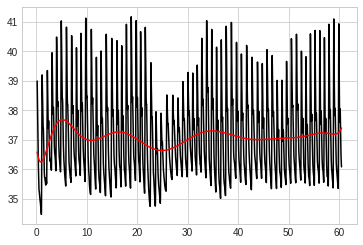

[903.  57.  57.  64.  64.  57.  58.  62.  67.  64.  53.  59.  64.  58.
  55.  57.  63.  65.  62.  61.  67.  64.  53.  57.  60.  53.  51.   0.
  57.  60.  61.  67.  67.  62.  59.  62.  64.  61.  58.  59.  61.  57.
  55.  56.  62.  64.  58.  59.  62.  66.  62.  60.  60.  67.  67.  65.
  62.  65.]

subject 8
_________________


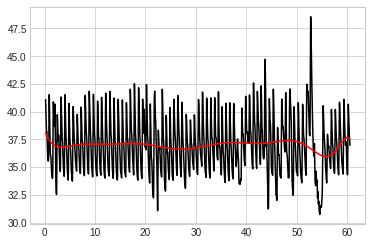

[374.  73.  76.  83.  75.  71.  72.  79.  74.  72.  72.  76.  73.  73.
  72.  71.  74.  74.  72.  74.  80.  76.  71.  81.  74.  79.  77.  72.
  68.  77.  76.  74.  71.  77.  82.  80.  77.  76.   0.  37.  80.  74.
  77.  79.  68.  75.  35.  78.  74.  70.  71.  69.   0.   0.   0.  18.
  67.  76.]

subject 9
_________________


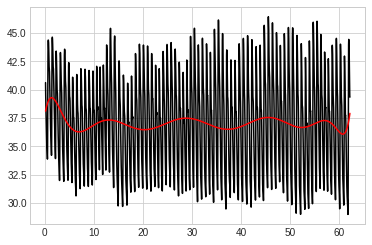

[903.  72.  73.  71.  69.  73.  72.  71.  71.  72.  79.  86.  91.  82.
  70.  64.  68.  76.  76.  75.  73.  71.  73.  80.  78.  72.  70.  70.
  74.  81.  77.  73.  72.  75.  75.  74.  70.  68.  73.  72.  70.  68.
  67.  68.  73.  72.  71.  72.  76.  72.  69.  67.  66.  69.  77.  77.
  77.  79.  76.  73.]

subject 10
_________________


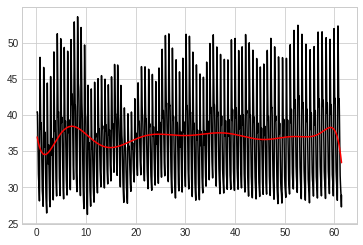

[960.  80.  82.  92.  88.  83.  86.  92.  88.  84.  84.  91.  87.  86.
  89.  94.  96.  83.  81.  85.  93.  88.  80.  80.  87.  95.  85.  83.
  80.  91.  93.  85.  83.  86.  92.  88.  83.  79.  84.  85.  82.  86.
  86.  79.  79.  82.  86.  83.  76.  74.  76.  79.  76.  73.  73.  71.
  75.  74.  73.]

subject 11
_________________


In [0]:
heartRateForSubjects()

In [0]:
import h5py
import torch
import torch.utils.data as data

class HDF5Dataset(data.Dataset):

    def __init__(self, file_path):
        super(HDF5Dataset, self).__init__()
        h5_file = h5py.File(file_path)
        self.data = h5_file.get('data')
        self.target = h5_file.get('label')

    def __getitem__(self, index):            
        return (torch.from_numpy(self.data[index,:,:,:]).float(),
                torch.from_numpy(self.target[index,:,:,:]).float())

    def __len__(self):
        return self.data.shape[0]

#!cp 'gdrive/My Drive/cohface/1/0/data.hdf5' 'temp_video/test.hdf5'
dataset = HDF5Dataset('temp_video/test.hdf5')
print(dataset)

TypeError: ignored

- First argument (mandatory) : random (0) or not random (1) 
- Second argument (mandatory) : the type of the video (avi, mp4, ...) 
- Third argument (mandatory) : number of videos wanted (if it's 0 or more than the amount of all the videos : all of them will be taken) 
- Other arguments : the list of directories or a directory that we want to look into

If there is a directory inside of the one given in the path it will be open as well.

If there isn't a path given, we will look in the current directory

In [0]:
script(0, 'avi', 2, '')